# JaX Flax --> ONNX

This notebook converts brax MLP networks to an ONNX checkpoint.

In [1]:
import os
os.environ["MUJOCO_GL"] = "glfw"


In [60]:
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo

from mujoco_playground.config import locomotion_params, manipulation_params
from mujoco_playground import locomotion, manipulation
import functools
import pickle
import jax.numpy as jp
import jax
import tf2onnx
import tensorflow as tf
from tensorflow.keras import layers
import onnxruntime as rt
from brax.training.acme import running_statistics
from mujoco_playground.config import locomotion_params
from mujoco_playground import registry
from datetime import datetime
from mujoco_playground import wrapper
from IPython.display import HTML, clear_output


import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp


In [61]:
env_name = "Go2JoystickFlatTerrain"
# ppo_params = locomotion_params.brax_ppo_config(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)

In [62]:
ppo_params

action_repeat: 1
batch_size: 256
discounting: 0.97
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.0003
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: privileged_state
normalize_observations: true
num_envs: 8192
num_evals: 2
num_minibatches: 32
num_resets_per_eval: 1
num_timesteps: 20
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 20

In [63]:
def identity_observation_preprocessor(observation, preprocessor_params):
  del preprocessor_params
  return observation

network_factory=functools.partial(
  ppo_networks.make_ppo_networks,
  **ppo_params.network_factory,
  # We need to explicitly call the normalization function here since only the brax
  # PPO train.py script creates it if normalize_observations is True.
  preprocess_observations_fn=running_statistics.normalize,
)

In [64]:
# env_cfg = locomotion.get_default_config(env_name)
# env = locomotion.load(env_name, config=env_cfg)
env_cfg = locomotion.get_default_config(env_name)
env = locomotion.load(env_name, config=env_cfg)

In [65]:
obs_size = env.observation_size
act_size = env.action_size
print(obs_size, act_size)

{'privileged_state': (123,), 'state': (48,)} 12


In [66]:
ppo_network = network_factory(obs_size, act_size)

In [67]:
output_path = f"bh_policy.onnx"

In [ ]:
# params = (params["normalizer_params"], params["policy_params"])

In [68]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

randomizer = registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)

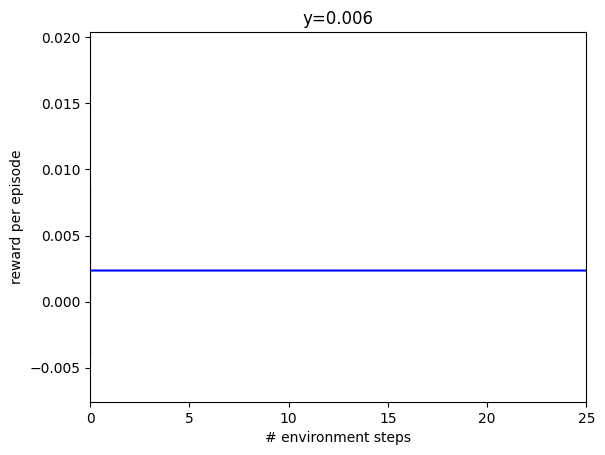

time to jit: 0:00:24.493945
time to train: 0:00:23.876519


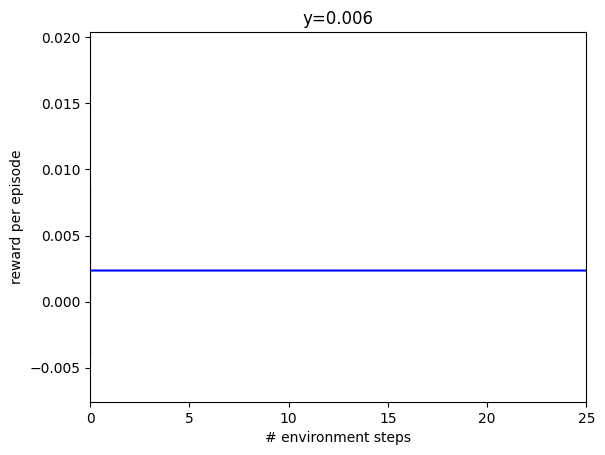

In [69]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [70]:
params

(RunningStatisticsState(mean={'privileged_state': Array([-1.6998471e-01, -3.5064016e-02, -5.0834704e-02,  5.3640449e-01,
        -2.3077182e-01, -3.3275053e-02, -8.2134809e-03, -1.0542257e-01,
        -9.4940078e-01, -4.1362286e-01, -9.8578431e-02, -2.5430387e-01,
         1.1145024e-01,  7.4144892e-02, -3.0603552e-01, -1.3428670e-01,
         1.0818565e-01, -2.0052485e-01,  2.2648922e-01,  6.6506051e-02,
        -3.2835621e-01, -1.1642497e+00, -2.3228630e-01, -6.9149417e-01,
         5.5276048e-01,  2.3983148e-01, -8.3887976e-01, -3.8230604e-01,
         2.7609903e-01, -6.0349131e-01,  5.4833233e-01,  1.6156992e-01,
        -9.5915997e-01, -9.4050758e-02,  1.3754715e-01, -3.1510881e-01,
        -4.4128957e-01, -1.5379481e-01, -2.0799983e-01,  3.0581575e-02,
         2.0158939e-01, -3.0030343e-01,  6.1655499e-02,  2.2020134e-01,
        -1.2760356e-01, -4.0093483e-03,  3.1857491e-03,  5.4417658e-03,
         5.3635007e-01, -2.3038009e-01, -3.3426326e-02, -5.6365085e-01,
         9.6617

In [ ]:
# make_inference_fn = ppo_networks.make_inference_fn(ppo_network)
# inference_fn = make_inference_fn(params, deterministic=True)

In [71]:
inference_fn = make_inference_fn(params, deterministic=True)

In [72]:
class MLP(tf.keras.Model):
    def __init__(
        self,
        layer_sizes,
        activation=tf.nn.relu,
        kernel_init="lecun_uniform",
        activate_final=False,
        bias=True,
        layer_norm=False,
        mean_std=None,
    ):
        super().__init__()

        self.layer_sizes = layer_sizes
        self.activation = activation
        self.kernel_init = kernel_init
        self.activate_final = activate_final
        self.bias = bias
        self.layer_norm = layer_norm

        if mean_std is not None:
            self.mean = tf.Variable(mean_std[0], trainable=False, dtype=tf.float32)
            self.std = tf.Variable(mean_std[1], trainable=False, dtype=tf.float32)
        else:
            self.mean = None
            self.std = None

        self.mlp_block = tf.keras.Sequential(name="MLP_0")
        for i, size in enumerate(self.layer_sizes):
            dense_layer = layers.Dense(
                size,
                activation=self.activation,
                kernel_initializer=self.kernel_init,
                name=f"hidden_{i}",
                use_bias=self.bias,
            )
            self.mlp_block.add(dense_layer)
            if self.layer_norm:
                self.mlp_block.add(layers.LayerNormalization(name=f"layer_norm_{i}"))
        if not self.activate_final and self.mlp_block.layers:
            if hasattr(self.mlp_block.layers[-1], 'activation') and self.mlp_block.layers[-1].activation is not None:
                self.mlp_block.layers[-1].activation = None

        self.submodules = [self.mlp_block]

    def call(self, inputs):
        if isinstance(inputs, list):
            inputs = inputs[0]
        if self.mean is not None and self.std is not None:
            print(self.mean.shape, self.std.shape)
            inputs = (inputs - self.mean) / self.std
        logits = self.mlp_block(inputs)
        loc, _ = tf.split(logits, 2, axis=-1)
        return tf.tanh(loc)

def make_policy_network(
    param_size,
    mean_std,
    hidden_layer_sizes=[256, 256],
    activation=tf.nn.relu,
    kernel_init="lecun_uniform",
    layer_norm=False,
):
    policy_network = MLP(
        layer_sizes=list(hidden_layer_sizes) + [param_size],
        activation=activation,
        kernel_init=kernel_init,
        layer_norm=layer_norm,
        mean_std=mean_std,
    )
    return policy_network

In [73]:
mean = params[0].mean["state"]
std = params[0].std["state"]

# Convert mean/std jax arrays to tf tensors.
mean_std = (tf.convert_to_tensor(mean), tf.convert_to_tensor(std))

tf_policy_network = make_policy_network(
    param_size=act_size * 2,
    mean_std=mean_std,
    hidden_layer_sizes=ppo_params.network_factory.policy_hidden_layer_sizes,
    activation=tf.nn.swish,
)

In [74]:
example_input = tf.zeros((1, obs_size["state"][0]))
example_output = tf_policy_network(example_input)
print(example_output.shape)

(48,) (48,)
(48,) (48,)
(1, 12)


In [75]:
import numpy as np
import tensorflow as tf

def transfer_weights(jax_params, tf_model):
    """
    Transfer weights from a JAX parameter dictionary to the TensorFlow model.

    Parameters:
    - jax_params: dict
      Nested dictionary with structure {block_name: {layer_name: {params}}}.
      For example:
      {
        'CNN_0': {
          'Conv_0': {'kernel': np.ndarray},
          'Conv_1': {'kernel': np.ndarray},
          'Conv_2': {'kernel': np.ndarray},
        },
        'MLP_0': {
          'hidden_0': {'kernel': np.ndarray, 'bias': np.ndarray},
          'hidden_1': {'kernel': np.ndarray, 'bias': np.ndarray},
          'hidden_2': {'kernel': np.ndarray, 'bias': np.ndarray},
        }
      }

    - tf_model: tf.keras.Model
      An instance of the adapted VisionMLP model containing named submodules and layers.
    """
    for layer_name, layer_params in jax_params.items():
        try:
            tf_layer = tf_model.get_layer("MLP_0").get_layer(name=layer_name)
        except ValueError:
            print(f"Layer {layer_name} not found in TensorFlow model.")
            continue
        if isinstance(tf_layer, tf.keras.layers.Dense):
            kernel = np.array(layer_params['kernel'])
            bias = np.array(layer_params['bias'])
            print(f"Transferring Dense layer {layer_name}, kernel shape {kernel.shape}, bias shape {bias.shape}")
            tf_layer.set_weights([kernel, bias])
        else:
            print(f"Unhandled layer type in {layer_name}: {type(tf_layer)}")

    print("Weights transferred successfully.")

In [76]:
transfer_weights(params[1]['params'], tf_policy_network)

Transferring Dense layer hidden_0, kernel shape (48, 512), bias shape (512,)
Transferring Dense layer hidden_1, kernel shape (512, 256), bias shape (256,)
Transferring Dense layer hidden_2, kernel shape (256, 128), bias shape (128,)
Transferring Dense layer hidden_3, kernel shape (128, 24), bias shape (24,)
Weights transferred successfully.


In [77]:
# Example inputs for the model
test_input = [np.ones((1, obs_size["state"][0]), dtype=np.float32)]

# Define the TensorFlow input signature
spec = [tf.TensorSpec(shape=(1, obs_size["state"][0]), dtype=tf.float32, name="obs")]

tensorflow_pred = tf_policy_network(test_input)[0]
# Build the model by calling it with example data
print(f"Tensorflow prediction: {tensorflow_pred}")

tf_policy_network.output_names = ['continuous_actions']

# opset 11 matches isaac lab.
model_proto, _ = tf2onnx.convert.from_keras(tf_policy_network, input_signature=spec, opset=11, output_path=output_path)

# Run inference with ONNX Runtime
output_names = ['continuous_actions']
providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)

I0000 00:00:1742672987.549767 1582359 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1742672987.550357 1582359 single_machine.cc:374] Starting new session
I0000 00:00:1742672987.599831 1582359 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1742672987.599896 1582359 single_machine.cc:374] Starting new session
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x151e31fc0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


(48,) (48,)
Tensorflow prediction: [ 0.57877153  0.11562523  0.03103878  0.8128518  -0.73248833  0.7977796
  0.8855875   0.92991817  0.6942467   0.07227529  0.9479612   0.39911473]
(48,) (48,)


In [ ]:
onnx_input = {
  'obs': np.ones((1, obs_size["state"][0]), dtype=np.float32)
}
# Prepare inputs for ONNX Runtime
onnx_pred = m.run(output_names, onnx_input)[0][0]

print("ONNX prediction:", onnx_pred)

In [ ]:
test_input = {
    'state': jp.ones(obs_size["state"]),
    'privileged_state': jp.zeros(obs_size["privileged_state"])
}
jax_pred, _ = inference_fn(test_input, jax.random.PRNGKey(0))
print(jax_pred)

In [ ]:
import matplotlib.pyplot as plt
print(onnx_pred.shape)
print(tensorflow_pred.shape)
print(jax_pred.shape)
plt.plot(onnx_pred, label='onnx')
plt.plot(tensorflow_pred, label='tensorflow')
plt.plot(jax_pred, label='jax')
plt.legend()
plt.show()

In [20]:
# env_cfg = locomotion.get_default_config(env_name)
# env = locomotion.load(env_name, config=env_cfg)
# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)

In [21]:
# # Test the policy.

# # env_cfg = locomotion.get_default_config(env_name)
# # env_cfg.init_from_crouch = 0.0
# # env = locomotion.load(env_name, config=env_cfg)
# # env_cfg = manipulation.get_default_config(env_name)
# # env = manipulation.load(env_name, config=env_cfg)
# # jit_reset = jax.jit(env.reset)
# # jit_step = jax.jit(env.step)

# x = 0.8
# y = 0.0
# yaw = 0.3
# command = jp.array([x, y, yaw])
# # actions = []

# states = [state := jit_reset(jax.random.PRNGKey(555))]
# state.info["command"] = command
# for _ in range(env_cfg.episode_length):
#   onnx_input = {'obs': np.array(state.obs["state"].reshape(1, -1))}
#   action = m.run(output_names, onnx_input)[0][0]
#   state = jit_step(state, jp.array(action))
#   state.info["command"] = command
#   states.append(state)
#   # actions.append(state.info["motor_targets"])
#   # actions.append(action)
#   if state.done:
#     print("Unexpected termination.")
#     break

In [22]:
# import mediapy as media
# fps = 1.0 / env.dt

# frames = env.render(
#     states,
#     camera="track",
#     width=640*2,
#     height=480*2,
# )
# media.show_video(frames, fps=fps, loop=False)